In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,matplotlib

Ethen 2017-03-10 21:37:10 

CPython 3.5.2
IPython 4.2.0

numpy 1.12.0
matplotlib 2.0.0


# Triple Exponential Smoothing - Holt Winters

Triple Exponential Smoothing, also known as the **Holt-Winters** method, is one of the many methods or algorithms that can be used to forecast data points in a series.


## Exponential Smoothing

In the next few examples we are going to be using the tiny time series below and our task to predict the next value of the time series.

In [2]:
time_series = np.array([3, 10, 12, 13, 12, 10, 12])
time_series

array([ 3, 10, 12, 13, 12, 10, 12])

One of the most naive mthod that we can use is the arithmetic average of all the previously observed data points. We take all the values we know, calculate the average and bet that that’s going to be the next value. Of course it won’t be it exactly, but it probably will be somewhere in the ballpark (e.g. your final school grade may be the average of all the previous grades).

\begin{align}
\hat{y}_{x+1} = \dfrac{1}{x}\sum_{i=1}^{x}y_i
\end{align}

- Where $\hat{y}_{x+1}$ refers to the predicted value at time $x + 1$

In [3]:
def average(series):
    return np.mean(series)

average(time_series)

10.285714285714286

An improvement over simple arithmetic average is the average of $n$ last points. The rationale here is that only the recent values matter. Calculation of the moving average involves what is sometimes called a "sliding window" of size $n$.

\begin{align}
\hat{y}_{x+1} = \dfrac{1}{x} \sum_{i=x - n}^{x}y_i
\end{align}

In [4]:
def moving_average(series, n):
    """moving average using n last points"""
    return np.mean(series[-n:])

# in this example, the predicted value is
# simply (12 + 10 + 12) / 3
moving_average(time_series, n = 3)

11.333333333333334

A weighted moving average is a moving average where within the sliding window values are given different weights, typically so that more recent points matter more. Exponentially weight moving average is a method where we consider all of the data points, while assigning exponentially smaller weights as we go back in time. The mathematical notation for this method is:

\begin{align}
\hat{y}_x = \alpha \cdot y_x + (1-\alpha) \cdot \hat{y}_{x-1}
\end{align}

To compute the formula, we pick an $0 < \alpha < 1$ and a starting value $\hat{y}_{0}$ (e.g. simply the first value of the observed data), and then calculate $\hat{y}_x$ recursively for $t = 1, 2, 3, \dots$. As we'll see in later sections, $\hat{y}_x$ is also refered to as levels.

We can think of $\alpha$ as the smoothing factor or smoothing coefficient, it will give more weight to the left side (the current value) when it’s higher (closer to 1) and more weight to the right side (the predicted previous value) when it’s lower (closer to 0). In other words, it is a memory decay rate. The higher the $\alpha$, the faster the method "forgets" about the past.

In [5]:
def exponential_smoothing(series, alpha):
    """given a series and alpha, return series of expoentially smoothed points"""
    results = np.zeros(series.shape[0])
    
    # first value remains the same as series,
    # as there is no history to learn from
    results[0] = series[0] 
    for t in range(1, series.shape[0]):
        results[t] = alpha * series[t] + (1 - alpha) * results[t - 1]
    
    return results

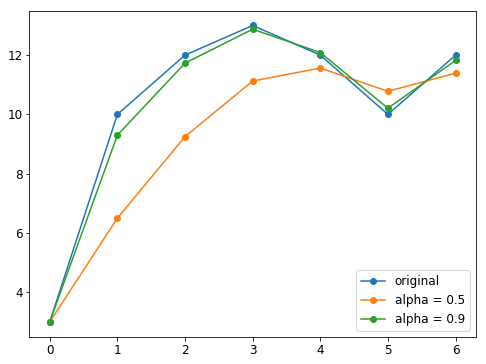

In [6]:
# fit different values of alpha
alpha_low = exponential_smoothing(time_series, alpha = 0.5)
alpha_high = exponential_smoothing(time_series, alpha = 0.9)

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.plot(time_series, '-o', label = 'original')
plt.plot(alpha_low, '-o', label = 'alpha = 0.5')
plt.plot(alpha_high, '-o', label = 'alpha = 0.9')
plt.legend(loc = 'lower right')
plt.show()

Looking at the above picture it is apparent that the $\alpha$ value of 0.9 follows the observed values much closer than 0.1. Keep in mind that each series has its best $\alpha$ value. The process of finding the best $\alpha$ is referred to as fitting and we will discuss it in later section.

One very important characteristic of exponential smoothing is that remarkably, they can only forecast the current level. If we look at the formula again $\hat{y}_x = \alpha \cdot y_x + (1-\alpha) \cdot \hat{y}_{x-1}$, we can see that in order to make the prediction for $\hat{y}_x$ we also need to have the observed value $y_x$. In some other software like R, if we were to use it to predict the future, it will simply assign all future prediction the last value of the time series.

## Double Exponential Smoothing

Double exponential smoothing (a.k.a the Holt method) is nothing more than exponential smoothing applied to both level and trend. The basic idea is saying if the time series has a trend, we can do better than just estimating the current level and using that to forecast the future observations. We will introduce two new notations: the current "trend", denoted by $T$ (we can think of it as the slope of the time series), as well as the current "level", denoted by $\ell$.

To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected $\hat{y}$.

\begin{align}
\ell_x &= \alpha y_x + (1-\alpha)(\ell_{x-1} + T_{x-1})& \mbox{level} \nonumber \\
T_x &= \beta(\ell_x - \ell_{x-1}) + (1-\beta)T_{x-1} & \mbox{trend} \nonumber \\
\hat{y}_{x+1} &= \ell_x + T_x & \mbox{1 step forecast}\\
\end{align}

- $\ell$, level is simply predicted point. But because now it’s going to be only part of calculation of the forecast (our forecast is a combination of predicted point and trend), we can no longer refer to it as $\hat{y}$
- The second equation introduces $0 < \beta< 1$, the trend coefficient. As with $\alpha$, some values of $\beta$ work better than others depending on the series. When $\beta$ is big, we won’t give too much weight to the past trends when estimating current trend
- Similarly to exponential smoothing, where we used the first observed value as the first expected, we can use the first observed trend as the first expected. Of course we need at least the first two points to compute the initial trend.

To perform k-step-ahead forecast, we can use simple linear extrapolation:

\begin{align}
\hat{y}_{x+1} &= \ell_x + k T_x
\end{align}

In [7]:
def double_exponential_smoothing(series, alpha, beta, n_ahead):
    """
    given a series, alpha, beta and n_head, number of forecast
    steps, perform the prediction
    """
    n_record = series.shape[0]
    results = np.zeros(n_record + n_ahead)

    # first value remains the same as series,
    # as there is no history to learn from;
    # and the initial trend is simply the slope/difference
    # between the first two value of the series
    results[0] = series[0]
    trend = series[1] - series[0]
    
    level = series[0]
    for t in range(1, n_record + 1):
        if t >= n_record:
            # forecasting new points
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend 
        results[t] = level + trend
    
    # for forecasting beyond the first new point,
    # the level and trend is all fixed
    if n_ahead > 1:
        results[n_record + 1:] = level + np.arange(2, n_ahead + 1) * trend
    
    return results

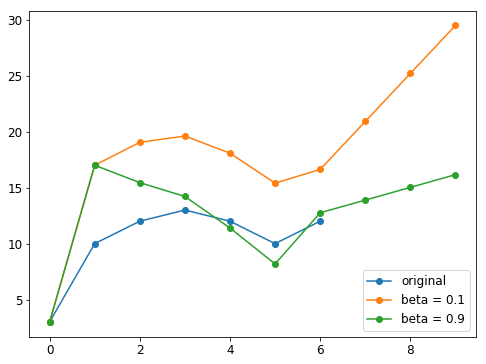

In [8]:
# using different beta
beta_low = double_exponential_smoothing(time_series, alpha = 0.9, beta = 0.1, n_ahead = 3)
beta_high = double_exponential_smoothing(time_series, alpha = 0.9, beta = 0.9, n_ahead = 3)

plt.plot(time_series, '-o', label = 'original')
plt.plot(beta_low, '-o', label = 'beta = 0.1')
plt.plot(beta_high, '-o', label = 'beta = 0.9')
plt.legend(loc = 'lower right')
plt.show()

Although it can now predictive future values, if we stare closer at the forecast formula $\hat{y}_{x+1} = \ell_x + k T_x$, we can see that once the trend ($T$) is estimated to be positive, all future predictions can only go up from the last value in the time series. On the hand, if the trend ($T$) is estimated to be negative, all future predictions can only go down.

## Triple Exponential Smoothing

The idea behind triple exponential smoothing (a.k.a **Holt-Winters Method**) is to apply exponential smoothing to the seasonal components, $S$, in addition to level and trend. The smoothing is applied across seasons, e.g. the seasonal component of the 3rd point into the season would be exponentially smoothed with the the one from the 3rd point of last season, 3rd point two seasons ago, etc. In math notation we now have four equations:

\begin{align}
\ell_x &= \alpha(y_x - S_{x-L}) + (1-\alpha)(\ell_{x-1} + T_{x-1})& \mbox{level} \\
b_x &= \beta(\ell_x - \ell_{x-1}) + (1-\beta) T_{x-1} & \mbox{trend} \\
S_x &= \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L} & \mbox{seasonal} \\
\hat{y}_{x+m} &= \ell_x + m T_x + S_{x-L+1+(m-1)modL}& \mbox{forecast}\\
\end{align}

- Note that when estimating the level $\ell_x$, we subtract the estimated seasonality from $y_x$. The trend part remains the same and when estimating the seasonality $S_x$, we subtract the estimated level from $\ell_x$
- We now have a third coefficient, $0 < \gamma < 1$ which is the smoothing factor for the seasonal component
- The index for the forecast, $\hat{y}_{x+m}$, is $x+m$ where $m$ can be any integer meaning we can forecast any number of points into the future while accounting for the previous value, trend and seasonality

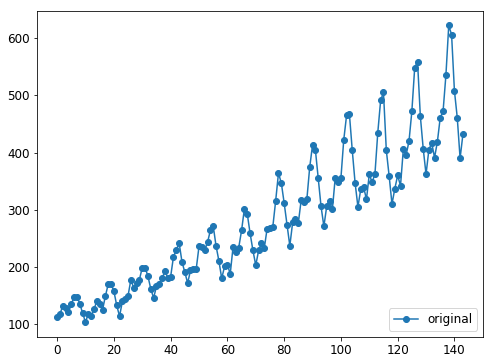

In [9]:
time_series = np.loadtxt('time.csv')

plt.plot(time_series, '-o', label = 'original')
plt.legend(loc = 'lower right')
plt.show()

In [10]:

# http://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n = 3):
    ret = np.cumsum(a, dtype = np.float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

a = np.arange(20)
moving_average(a)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.])

https://www.otexts.org/fpp/7/5

# Reference

- [Blog: Holt-Winters Forecasting for Dummies (or Developers) - Part I](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)
- [Blog: Holt-Winters Forecasting for Dummies - Part II](https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/)
- [Blog: Holt-Winters Forecasting for Dummies - Part III](https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/)